# MODEL OPTIMIZATION

In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RANSACRegressor
from sklearn.cross_validation import train_test_split, cross_val_score
# from xgboost import XGBRegressor #faster version of gradient boosting regressor
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
with open('model_opt_train_scores.plk','rb') as f:
    train_pickle = pickle.load(f)
with open('model_opt_test_scores.plk','rb') as f:
    test_pickle = pickle.load(f)

In [6]:
train_pickle

{'Gradient Boost': [array([ 0.1223124 ,  0.19794912,  0.27085387,  0.34028494,  0.41444008]),
  array([ 0.14824164,  0.24629178,  0.32742355,  0.40939547,  0.49595255]),
  array([ 0.16412742,  0.27445263,  0.36227547,  0.45425053,  0.54449455]),
  array([ 0.17519029,  0.29357501,  0.38899756,  0.48669617,  0.57725783]),
  array([ 0.18339668,  0.30871557,  0.40978536,  0.51166513,  0.60144719])],
 'Random Forest': [array([ 0.04010479,  0.05908448,  0.08165475,  0.10453716,  0.13264063]),
  array([ 0.04032215,  0.05891103,  0.08146616,  0.10415089,  0.1322653 ]),
  array([ 0.04033409,  0.05912052,  0.0816457 ,  0.10433563,  0.13244944]),
  array([ 0.04034061,  0.05897687,  0.08163483,  0.10424303,  0.13225089]),
  array([ 0.04033516,  0.05896249,  0.08152186,  0.10410829,  0.13207134])]}

## LOAD DATA

In [6]:
df = pd.read_csv('data/wheat-2013-supervised-edited.csv')
drop_cols = ['Latitude','Longitude'] + [df.columns[0]]
df.drop(drop_cols,axis=1,inplace=True)
df.head()

,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,precipIntensity,precipIntensityMax,precipProbability,precipAccumulation,precipTypeIsRain,precipTypeIsSnow,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield
0,35.70,20.85,0.00,29.53,0.91,0.0000,0.0000,0.00,0.000,0,0,1027.13,35.70,27.48,2.46,214,1.18,134.110657,0,35.7
1,35.10,26.92,0.00,29.77,0.93,0.0001,0.0019,0.05,0.000,1,0,1026.87,35.10,26.92,2.83,166,1.01,131.506592,0,35.7
2,33.38,26.95,0.00,29.36,0.94,0.0001,0.0022,0.06,0.020,0,1,1026.88,33.38,26.95,2.95,158,1.03,131.472946,0,35.7
3,28.05,25.93,0.91,29.47,0.94,0.0002,0.0039,0.15,0.036,0,1,1026.37,33.19,27.17,2.89,153,1.84,131.288300,0,35.7
4,28.83,25.98,0.91,29.86,0.94,0.0003,0.0055,0.24,0.000,1,0,1026.19,33.85,27.07,2.97,156,1.85,131.288300,0,35.7


## OPTIMIZE MODELS

In [3]:
with open('SBS_feat_set.plk','rb') as f:
    sbs_dict = pickle.load(f)

In [8]:
def optimizer(name,*params):
    if name == 'Linear':
        k, model = 8, RANSACRegressor(base_estimator=LinearRegression(),max_trials=100,min_samples=params[0])
    elif name == 'Random Forest':
        k, model = 4, RandomForestRegressor(n_estimators=params[0],max_depth=params[1],random_state=42)
    elif name == 'Gradient Boost':
        k, model = 8, GradientBoostingRegressor(n_estimators=params[0],max_depth=params[1])
#         k, model = 8, XGBRegressor(n_estimators=params[0],max_depth=params[1]) #XG Boost (same as gradient boost)
    X = np.matrix(df.ix[:,:-1])[:,list(sbs_dict[name][k])][:500]
    y = np.array(df.ix[:,-1])[:500]
    X_std = StandardScaler().fit_transform(X)
    y_std = StandardScaler().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X_std,y_std,test_size=0.25,random_state=42)
    results = model.fit(X_train,y_train)
    train_score = np.mean(cross_val_score(results,X_train,y_train,cv=8))
    test_score = results.score(X_test,y_test)
    return train_score, test_score

In [ ]:
name = 'Linear'
test_scores = []
train_scores= []
param_list = []
min_samp_size = 100#70000
max_samp_size = 200#100000
for param in np.arange(min_samp_size,max_samp_size+1,100): #10000):
    train_score, test_score = optimizer(name,param)
    train_scores.append(train_score)
    test_scores.append(test_score)
    param_list.append(param)
plt.figure(figsize=(10,7))
plt.plot(param_list,train_scores,marker='^')
plt.plot(param_list,test_scores,marker='o')
plt.legend(['Train','Test'],loc=0)
plt.title('Linear Regression')
plt.xlabel('RANSAC Sample Size')
# plt.axis([min_samp_size,max_samp_size,0,1])
plt.ylabel('Score')
plt.grid(True)
plt.show()

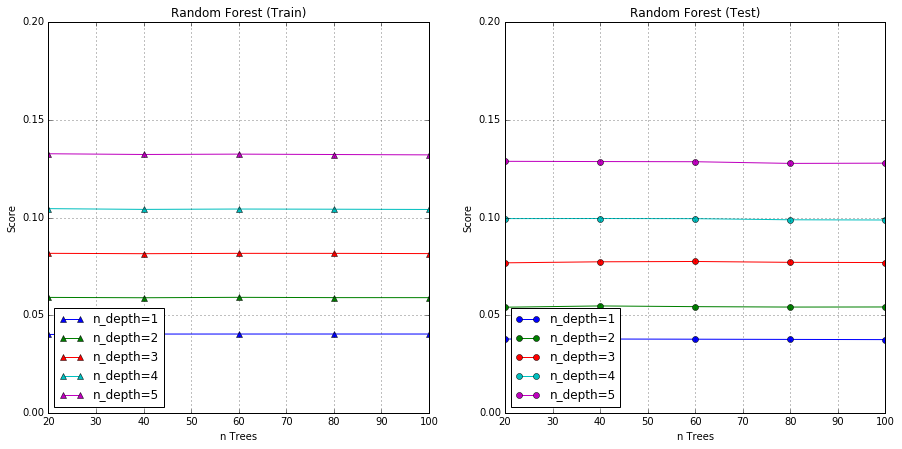

In [5]:
name = 'Random Forest'
test_scores = []
train_scores= []
param_list = []
min_trees,max_trees = 20,100
min_depth,max_depth = 1,5
for param1 in np.arange(min_trees,max_trees+1,20):
    bin1 = []
    bin2 = []
    param_list.append(param1)
#     for param2 in np.arange(min_depth,max_depth+1,1):
#         train_score, test_score = optimizer(name,param1,param2)
#         bin1.append(train_score)
#         bin2.append(test_score)
#     train_scores.append(np.array(bin1))
#     test_scores.append(np.array(bin2))

train_scores= train_pickle[name]    
test_scores = test_pickle[name]

fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_figheight(7)
fig.set_figwidth(15)
ax = axs[0]
ax.plot(param_list,train_scores,marker='^')
ax.legend(['n_depth={}'.format(n) for n in np.arange(1,max_depth+1,1)],loc=3)
ax.set_title('Random Forest (Train)')
ax.axis([min_trees,max_trees,0,0.2])
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)

ax = axs[1]
ax.plot(param_list,test_scores,marker='o')
ax.legend(['n_depth={}'.format(n) for n in np.arange(1,max_depth+1,1)],loc=3)
ax.set_title('Random Forest (Test)')
ax.axis([min_trees,max_trees,0,0.2])
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)

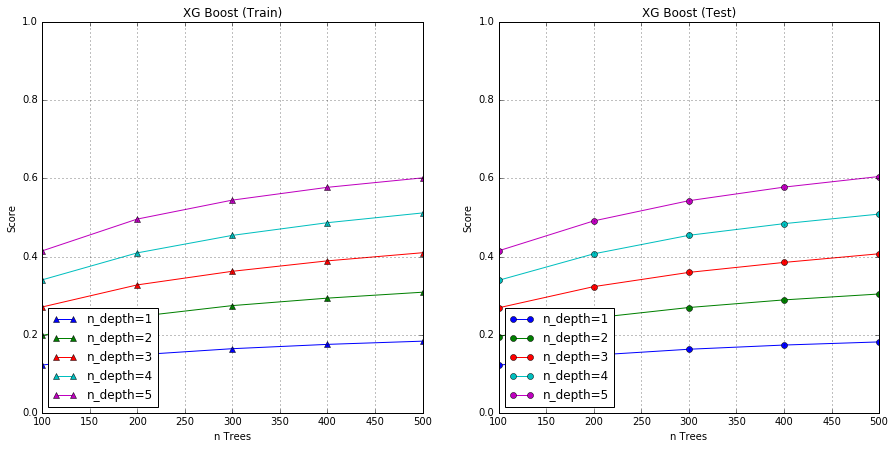

In [10]:
name = 'Gradient Boost'
# test_scores = []
# train_scores= []
param_list = []
min_trees,max_trees = 100,500
min_depth,max_depth = 1,5

for param1 in np.arange(min_trees,max_trees+1,100):
#     bin1 = []
#     bin2 = []
    param_list.append(param1)
#     for param2 in np.arange(min_depth,max_depth+1,1):
#         train_score, test_score = optimizer(name,param1,param2)
#         bin1.append(train_score)
#         bin2.append(test_score)
#     train_scores.append(np.array(bin1))
#     test_scores.append(np.array(bin2))



train_scores= train_pickle[name]    
test_scores = test_pickle[name]

fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_figheight(7)
fig.set_figwidth(15)
ax = axs[0]
ax.plot(param_list,train_scores,marker='^')
ax.legend(['n_depth={}'.format(n) for n in np.arange(min_depth,max_depth+1,1)],loc=3)
ax.set_title('XG Boost (Train)')
ax.axis([min_trees,max_trees,0,1])
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)

ax = axs[1]
ax.plot(param_list,test_scores,marker='o')
ax.legend(['n_depth={}'.format(n) for n in np.arange(min_depth,max_depth+1,1)],loc=3)
ax.set_title('XG Boost (Test)')
ax.axis([min_trees,max_trees,0,1])
ax.set_xlabel('n Trees')
ax.set_ylabel('Score')
ax.grid(True)

In [ ]:
# model = ExtraTreesRegressor()
# params = {'n_estimators':[30,40,50,60,70,80,90,100]}
# grid_ = GridSearchCV(model, params)
# grid_.fit(X_train, y_train)
# best_model = grid_.best_estimator_
# best_model

## PICKLE MODEL

I like to pickle my models and/or anything that may be utilized in a production line later down the line.

In [ ]:
# filename = 'wheat_ET_model.plk'
# with open(filename, 'wb') as f:
#     pickle.dump(best_model, f)

In [2]:
import pickle
with open('model_opt_test_scores.plk','rb') as f:
    test_scores = pickle.load(f)

with open('model_opt_train_scores.plk','rb') as f:
    train_scores = pickle.load(f)    

In [3]:
print test_scores

{'Random Forest': [array([ 0.03776551,  0.05406429,  0.07678797,  0.09944242,  0.12876581]), array([ 0.03778458,  0.05471549,  0.07731616,  0.09947768,  0.12864872]), array([ 0.03768327,  0.05435609,  0.07748048,  0.09940684,  0.12856169]), array([ 0.03757413,  0.05414157,  0.07704068,  0.09883323,  0.127699  ]), array([ 0.03747812,  0.05418681,  0.07692758,  0.09872425,  0.12782298])], 'Gradient Boost': [array([ 0.12184332,  0.19532494,  0.26881227,  0.33918064,  0.41470731]), array([ 0.14747405,  0.24274439,  0.32301907,  0.40695041,  0.49130032]), array([ 0.16270996,  0.26953883,  0.35945251,  0.45437426,  0.54299212]), array([ 0.17345403,  0.28904247,  0.38499012,  0.4842335 ,  0.57775676]), array([ 0.18146622,  0.30415458,  0.40713506,  0.50875417,  0.60492643])]}


## References

https://www.researchgate.net/post/How_to_determine_the_number_of_trees_to_be_generated_in_Random_Forest_algorithm